# Vázquez Martínez Fredin Alberto
# Modelos de lenguaje Neuronales

### Sacar los embeddings de las palabras del vocabulario

Se entrenará la red para poder extraer los embeddings, la razón se explica más adelante.

In [1]:
# bibliotecas a usar 
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import numpy as np
import nltk

nltk.download('reuters')
nltk.download('gutenberg')
nltk.download('punkt_tab')

from nltk.corpus import reuters
from nltk.corpus import gutenberg
from nltk import ngrams

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# bibliotecas adicionales
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from collections import Counter
import matplotlib.style as mplstyle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
from nltk.stem import WordNetLemmatizer

mplstyle.use('seaborn-v0_8') # Configuración de la gráfica 
plt.style.context({ 
    'axes.edgecolor': '0.8',
    'xtick.color': '0.3',
    'ytick.color': '0.3',
    'grid.color': '0.85',
    'figure.facecolor': 'white'
})


[nltk_data] Downloading package reuters to
[nltk_data]     /Users/fredinvazquez/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/fredinvazquez/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/fredinvazquez/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Cargando funciones creadas en clase

In [4]:
###############################################
#
#   USANDO FUNCIONES CREADAS EN CLASE
#
###############################################

# Arquitectura de la red neuronal
class TrigramModel(nn.Module):
    """Clase padre: https://pytorch.org/docs/stable/generated/torch.nn.Module.html"""

    def __init__(self, vocab_size, embedding_dim, context_size, h):
        super(TrigramModel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, h)
        self.linear2 = nn.Linear(h, vocab_size)

    def forward(self, inputs):
        # x': concatenation of x1 and x2 embeddings   -->
        # self.embeddings regresa un vector por cada uno de los índices que se les pase como entrada.
        # view() les cambia el tamaño para concatenarlos
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        # h: tanh(W_1.x' + b)  -->
        out = torch.tanh(self.linear1(embeds))
        # W_2.h                 -->
        out = self.linear2(out)
        # log_softmax(W_2.h)      -->
        # dim=1 para que opere sobre renglones, pues al usar batchs tenemos varios vectores de salida
        log_probs = F.log_softmax(out, dim=1)

        return log_probs


UNK_LABEL = "<UNK>"
def get_words_indexes(words_freqs: dict) -> dict:
    """Calcula los indices de las palabras dadas sus frecuencias"""
    result = {}
    for idx, word in enumerate(words_freqs.keys()):
        # Happax legomena happends
        if words_freqs[word] == 1:
            # Temp index for unknowns
            result[UNK_LABEL] = len(words_freqs)
        else:
            result[word] = idx

    return {word: idx for idx, word in enumerate(result.keys())}, {idx: word for idx, word in enumerate(result.keys())}


def get_words_freqs(corpus: list[list[str]]):
    """Calcula la frecuencia de las palabras en un corpus"""
    words_freqs = {}
    for sentence in corpus:
        for word in sentence:
            words_freqs[word] = words_freqs.get(word, 0) + 1
    return words_freqs

def preprocess_corpus(corpus: list[str]) -> list[str]:
    """Función de preprocesamiento

    Esta función está diseñada para preprocesar
    corpus para modelos del lenguaje neuronales.
    Agrega tokens de inicio y fin, normaliza
    palabras a minusculas
    """
    preprocessed_corpus = []
    for sent in corpus:
        result = [word.lower() for word in sent]
        # Al final de la oración
        result.append("<EOS>")
        result.insert(0, "<BOS>")
        preprocessed_corpus.append(result)
    return preprocessed_corpus



# CONSTANTES DEFINIDAS
EMBEDDING_DIM = 200
CONTEXT_SIZE = 2 # ya que tenemos trigramas
BATCH_SIZE = 256
H = 100
torch.manual_seed(42)

# Tamaño del Vocabulario
corpus = preprocess_corpus(reuters.sents())
words_freqs = get_words_freqs(corpus)
words_indexes, index_to_word = get_words_indexes(words_freqs)
V = len(words_indexes)


def get_model(path: str) -> TrigramModel:
    """Obtiene modelo de pytorch desde disco"""
    model_loaded = TrigramModel(V, EMBEDDING_DIM, CONTEXT_SIZE, H)

    model_loaded.load_state_dict(torch.load(path, map_location=device))
    model_loaded.eval()
    return model_loaded

def get_word_id(words_indexes: dict, word: str) -> int:
    """Obtiene el id de una palabra dada

    Si no se encuentra la palabra se regresa el id
    del token UNK
    """
    unk_word_id = words_indexes[UNK_LABEL]
    return words_indexes.get(word, unk_word_id)


def get_train_test_data(corpus: list[list[str]], words_indexes: dict, n: int) -> tuple[list, list]:
    """Obtiene el conjunto de train y test

    Requerido en el step de entrenamiento del modelo neuronal
    """
    x_train = []
    y_train = []
    for sent in corpus:
        n_grams = ngrams(sent, n)
        for w1, w2, w3 in n_grams:
            x_train.append([get_word_id(words_indexes, w1), get_word_id(words_indexes, w2)])
            y_train.append([get_word_id(words_indexes, w3)])
    return x_train, y_train

## **Realizando el entrenamiento del modelo para la obtención de sus embeddings**

Se optó por entrenar la red neuronal debido a un problema con los modelos entrenados que fueron subidos al drive, se explica más adelante. 

La red nueronal básicamente es entrenada para predir la siguiente palabra en un contexto de n-gramas, lo visto en clase es que es recomendable usar trigramas, por ello la red nueronal se pasa como contexto dos palabras y su objetivo es predecir la tercer palabra dado ese contexto.

Los embeddings se extraen por medio de la capa ajustada *self.embeddings*

In [ ]:
def clean_corpus(texts, string_line=True, stopping=True, pos='v'):
    """
    Function to clean up survey answers and return list for NLP processing
    --------PARAMETERS---------
    texts: list objects that contains survey response strings
    string_line: if True, each returned survey response is a single string
    if False, each response is a list of words in the original sequence
    stopping: (default) if True, filter stopwords
    pos: (default) if 'v', lemmatize input words as verbs;
    if 'n', lemmatize input words as nouns
    """
    cleaned = []
    i = 0
    stop = set(stopwords.words("english"))
    # print("$$$ empty cleaned created")
    print(">>>> response cleaning initiated")
    for text in texts:
        if (i + 1) % 500 == 0:
            print(f">>>> cleaning response #{i + 1} out of {len(texts)}")
        try:
            text = re.sub("[^a-zA-Z]", " ", text)
            text = word_tokenize(text)
            text = [t.lower() for t in text]
            if stopping:
                text = [t for t in text if t not in stop]
            lemmatizer = WordNetLemmatizer()
            text = [lemmatizer.lemmatize(t, pos=pos) for t in text]
            # TODO: determine which lemmatizer to use for this project
            cleaned.append(text)
        except TypeError:
            cleaned.append([])
        i += 1
    if string_line:
        cleaned = [" ".join(t) for t in cleaned]
    return cleaned

In [8]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}")

# 1. Pérdida. Negative log-likelihood loss
loss_function = nn.NLLLoss()

# 2. Instanciar el modelo y enviarlo a device
model = TrigramModel(V, EMBEDDING_DIM, CONTEXT_SIZE, H).to(device)

# 3. Optimización. ADAM optimizer
optimizer = optim.Adam(model.parameters(), lr = 2e-3)


x_train, y_train = get_train_test_data(corpus, words_indexes, n=3)
train_set = np.concatenate((x_train, y_train), axis=1)
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE)

# ------------------------- TRAIN & SAVE MODEL ------------------------
EPOCHS = 5
for epoch in range(EPOCHS):
    st = time.time()
    print("\n--- Training model Epoch: {} ---".format(epoch))
    for it, data_tensor in enumerate(train_loader):
        # Mover los datos a la GPU
        context_tensor = data_tensor[:,0:2].to(device)
        target_tensor = data_tensor[:,2].to(device)

        model.zero_grad()

        # FORWARD:
        log_probs = model(context_tensor)

        # compute loss function
        loss = loss_function(log_probs, target_tensor)

        # BACKWARD:
        loss.backward()
        optimizer.step()

        if it % 500 == 0:
            print("Training Iteration {} of epoch {} complete. Loss: {}; Time taken (s): {}".format(it, epoch, loss.item(), (time.time()-st)))
            st = time.time()

    # saving model
    model_path = f'model_{device}_context_{CONTEXT_SIZE}_epoch_{epoch}.dat'
    torch.save(model.state_dict(), model_path)
    print(f"Model saved for epoch={epoch} at {model_path}")


Training on device cpu

--- Training model Epoch: 0 ---
Training Iteration 0 of epoch 0 complete. Loss: 9.939767837524414; Time taken (s): 0.04611706733703613
Training Iteration 500 of epoch 0 complete. Loss: 5.791366100311279; Time taken (s): 10.236343145370483
Training Iteration 1000 of epoch 0 complete. Loss: 5.217307090759277; Time taken (s): 10.101185083389282
Training Iteration 1500 of epoch 0 complete. Loss: 3.9488346576690674; Time taken (s): 10.44129204750061
Training Iteration 2000 of epoch 0 complete. Loss: 5.06322717666626; Time taken (s): 10.495323181152344
Training Iteration 2500 of epoch 0 complete. Loss: 4.599907875061035; Time taken (s): 11.15473198890686
Training Iteration 3000 of epoch 0 complete. Loss: 4.076577663421631; Time taken (s): 11.604212999343872
Training Iteration 3500 of epoch 0 complete. Loss: 4.546928882598877; Time taken (s): 12.779670000076294
Training Iteration 4000 of epoch 0 complete. Loss: 5.639043807983398; Time taken (s): 11.986547231674194
Trai

## Obteniendo los embeddings

Podemos extraer los embeddings de la capa ajustada durante el entrenamiento, el cual se encuentra en **self.embeddings**.

In [5]:
PATH = "model_cpu_context_2_epoch_14.dat"
model = get_model(PATH)

W1 = "<BOS>"
W2 = "my"

IDX1 = get_word_id(words_indexes, W1)
IDX2 = get_word_id(words_indexes, W2)

# Obtenemos Log probabidades p(W3|W2,W1)
device = 'cpu'
probs = model(torch.tensor([[IDX1,  IDX2]]).to(device)).detach().tolist()

### **Problemática de usar el modelo entrenado**
El problema que se tiene al intentar utilizar este modelo cargado es el vocabulario utilizado. Este modelo fue creado con un vocabulario más pequeño del que tenemos actualmente, así mismo no contamos con un diccionario para poder hacer el mapeo de palabra a índices. Es por esto que no se pudo utilizar este modelo para obtener los embeddings y se optó por entrenar la red neuronal. 

In [221]:
# import torch

# checkpoint = torch.load("langmodel_bengio_quijote_cuda_9.dat",map_location=torch.device('cpu'))

# pretrained_embeddings = checkpoint["embeddings.weight"]  # [12028, 200]
# pretrained_embedding_dim = pretrained_embeddings.size(1)  # 200

### Usando los embeddings 

In [222]:
# 2. Extraer embeddings
embeddings = model.embeddings.weight.data.numpy()  # Convertir a numpy

# 3. Ejemplo: Embedding de la primera palabra
print("Embedding de la palabra con índice 0:\n", embeddings[0])

print('\n\nDimensiones de los embeddings:',embeddings.shape)

Embedding de la palabra con índice 0:
 [ 1.1362268   1.045292    0.14654364 -0.31199175  0.10927232 -0.8248381
  0.02721553 -1.0171074  -0.24350046  0.27999383  0.19581509 -0.05222154
  0.11016086 -0.23249073 -0.596323   -0.0291161   0.64750755  0.2478652
  0.00735946  0.5310708  -0.05459166 -0.01971737  0.75173205  0.7264815
 -0.05387101  0.8899814  -0.20338027  0.68053967 -0.23817627  0.13891473
  0.34399158  0.30424762 -0.11879724 -0.27417576 -0.43802357  0.02934415
  0.09253547 -0.2005406  -0.06822722 -0.435371   -0.1047378   0.4423327
 -0.44958112 -0.3518526  -0.80623096  0.8433174  -0.76132506  0.02982375
 -0.527611   -0.3523703   0.11929703 -0.04996153 -0.61480093  0.07506186
 -0.17043383 -0.39790636 -0.5724945   0.37392268 -0.03039419 -0.1864457
  0.02490402  0.9008054  -0.44128186  0.9181134   0.45654917  0.7744068
  0.58874863  0.99541533  0.04194385  0.42558607 -0.88688797  0.73855543
 -0.4740369   0.40537095  0.48614323 -0.01056574  0.3266919  -0.29376552
 -0.8432543  -0.02

## Visualización en 2D de los embeddings de palabras más frecuentes

Para poder realizar la visualización 2D de los embeddings se consideró realizar ciertas modificaciones para poder tener algo más representativo.

Para esto, se hizo un preprocesamiento antes de hacer la representación:
* Remover Stopwords
* Convertir a lowercase
* Remover Carácteres especiales
* Remover valores numéricos
* Remover etiquetas

El preprocesamiento se hizó usando NLTK español.

Para la representación en dos dimensiones fue necesario tener que disminuir las dimensiones, ya que teníamos vectores de 200 de longitud. Por lo mismo de lo anterior, se aplicó dos técnicas de reducción de dimensionalidad:
* TSNE: este método resalta por reducción dimensión y ser destinado a las representaciones gráficas.
* PCA: usando componentes principales para la reducción de dimensión basado en los que representan más los datos.

In [229]:


# Se descarga los recursos adecuados para poder usar nltk durante el preprocesamiento.
nltk.download(['stopwords', 'punkt'], quiet=True)

def preprocess_corpus(corpus, word_to_idx, lang='english'):
    """
    Preprocesa un corpus eliminando stopwords (palabras vacías), números, etiquetas especiales y caracteres no deseados.
    
    Parámetros
    ----------
    corpus : list o str
        Corpus de texto de entrada (puede ser una lista de palabras o una cadena de texto crudo)
    word_to_idx : dict
        Diccionario que mapea palabras a índices
    lang : str, opcional
        Idioma para las stopwords ('spanish' o 'english') (por defecto: 'spanish')
    
    Retorna
    -------
    list
        Lista de palabras preprocesadas que existen en word_to_idx
    
    Ejemplos
    --------
    >>> preprocess_corpus("Este es un texto de ejemplo.", word_to_idx)
    ['texto', 'ejemplo']
    """

    stop_words = set(stopwords.words(lang)) # stopwords

    if isinstance(corpus, str): # Tokenizamos el corpus en caso que se nos de el corpus como un solo string. NLTK tokeniza por palabra básicamente
        words = word_tokenize(corpus, language=lang)
    else:
        words = corpus
    
    processed_words = []
    for word in words:
        word = re.sub(r'[^a-zA-ZáéíóúñÁÉÍÓÚÑ]', '', word.lower())  # Se remueve carácteres especiales y se hace minúsculas.
        
        if (not word or 
            word in stop_words or
            word in ['<bos>', '<eos>', '<unk>', '<pad>']  # Eliminar etiquetas.
            # or word.isdigit() # podemos también considerar remover dígitos, pero se decidió no hacerlo
            ):
            continue
            
        if word in word_to_idx:
            processed_words.append(word)
                
    return processed_words



def visualize_word_embeddings(model, word_to_idx, corpus, top_n=50, 
                            random_state=42, method='tsne', figsize=(12, 6),
                            lang='english'):
    """
    Visualiza embeddings de palabras en espacio 2D para las palabras más frecuentes con estilo moderno.
    
    Parámetros
    ----------
    model : TrigramModel
        Instancia del modelo TrigramModel entrenado
    word_to_idx : dict
        Diccionario que mapea palabras a sus índices correspondientes
    corpus : list o str
        Corpus de texto de entrada (puede ser lista de palabras o texto sin procesar)
    top_n : int, opcional
        Número de palabras más frecuentes a visualizar (por defecto: 50)
    random_state : int, opcional
        Semilla aleatoria para reproducibilidad (por defecto: 42)
    method : {'tsne', 'pca'}, opcional
        Método de reducción de dimensionalidad (por defecto: 'tsne')
    figsize : tuple, opcional
        Tamaño de la figura en pulgadas (por defecto: (12, 4))
    lang : str, opcional
        Idioma para stopwords ('spanish' o 'english') (por defecto: 'spanish')
    
    Retorna
    -------
    None
        Muestra el gráfico generado con matplotlib
    
    Ejemplos
    --------
    >>> visualize_word_embeddings(model, word_to_idx, corpus, top_n=30)
    >>> visualize_word_embeddings(model, word_to_idx, "Texto sin procesar", method='pca')
    """
    flat_corpus = [word for sublist in corpus for word in sublist]
    valid_words = preprocess_corpus(flat_corpus, word_to_idx, lang)
    
    embeddings = model.embeddings.weight.data.cpu().numpy() # Obtenemos los embeddings
    
    # Obtenemos las palabras más comúnes
    word_counts = Counter(valid_words) 
    actual_top_n = min(top_n, len(word_counts)) # no nos pasamos de la cantidad del tamaño del corpus
    top_words = [word for word, _ in word_counts.most_common(actual_top_n)]
    word_indices = [word_to_idx[word] for word in top_words]
    selected_embeddings = embeddings[word_indices] # seleccionamos sus embeddings 
    
    # reducción de dimensión, actualmente el modelo genera embeddings de longitud 200.
    if method.lower() == 'tsne':
        reducer = TSNE(n_components=2, random_state=random_state,
                      perplexity=min(15, actual_top_n-1))
    else:
        reducer = PCA(n_components=2, random_state=random_state)
    reduced_embeddings = reducer.fit_transform(selected_embeddings)
    
    # Visualización
    plt.figure(figsize=figsize, dpi=100)
    ax = plt.gca()
    
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, actual_top_n))
    
    scatter = ax.scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=colors,
        alpha=0.7,
        edgecolors='white',
        linewidth=0.5,
        s=120
    )
    
    for i, word in enumerate(top_words):
        ax.annotate(
            word,
            xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]),
            xytext=(5, 2),
            textcoords='offset points',
            ha='left',
            va='bottom',
            fontsize=9,
            color='0.3',
            bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.6, lw=0)
        )
    
    ax.set_title(f'Top {actual_top_n} Palabras Frecuentes\nReducción con {method.upper()}',
                pad=20, fontsize=13, color='0.3')
    ax.set_xlabel('Componente 1', labelpad=10, color='0.4')
    ax.set_ylabel('Componente 2', labelpad=10, color='0.4')
    ax.grid(True, linestyle=':', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

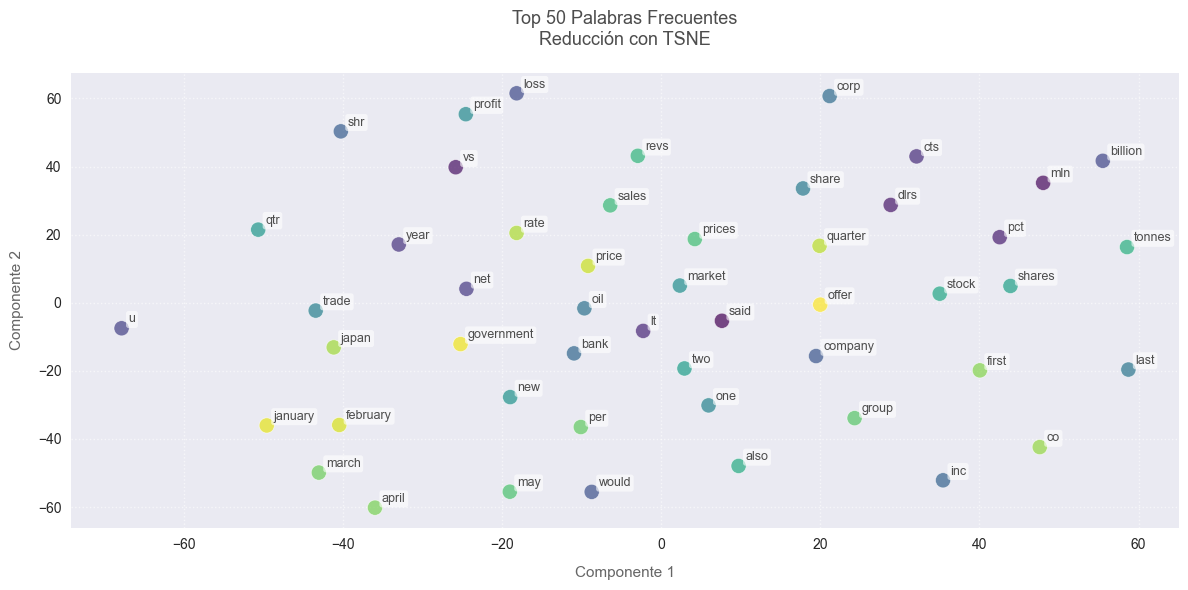

In [230]:
visualize_word_embeddings(
    model=model,
    word_to_idx=words_indexes,
    corpus=corpus,
    top_n=50,
    method='tsne',
    lang='english'
)

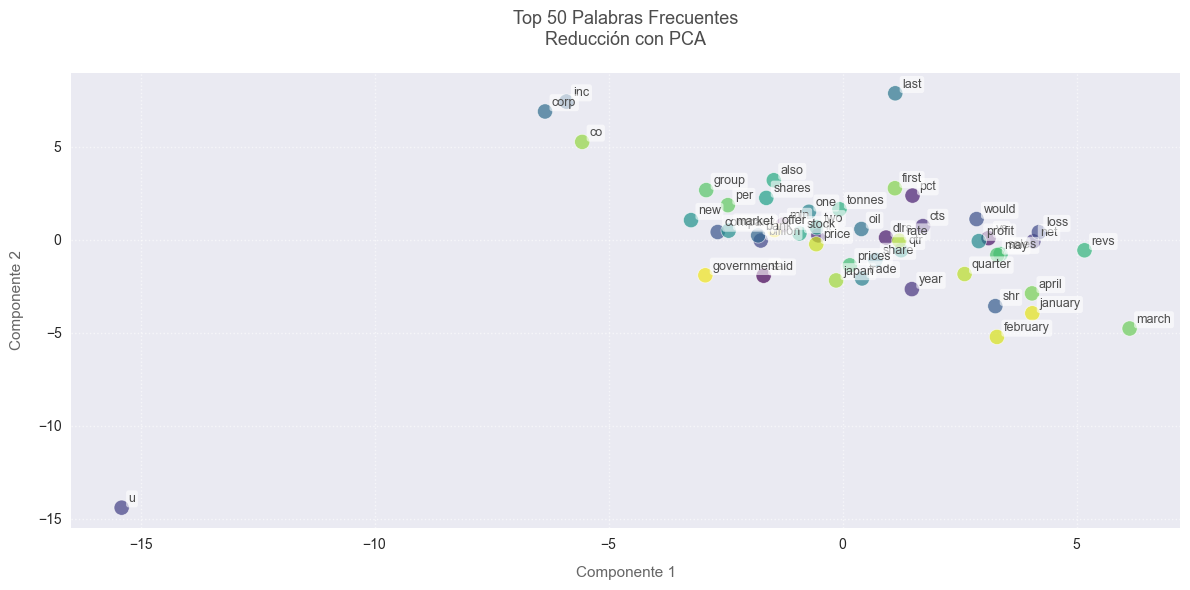

In [231]:
visualize_word_embeddings(
    model=model,
    word_to_idx=words_indexes,
    corpus=corpus,
    top_n=50,
    method='pca',
    lang='english'
)

De las representaciones anteriores, se puede destacar más intepretabilidad usando TSNE.

De las gráficas podemos destacar que se tiende a una agrupación o similitud semántica para las palabras:
* Meses: podemos notar que hay agrupamientos de meses, tales como enero y febrero, o marzo y abril.
* Uso de modales como would y may que están cercanos
* Números como one y two
* Términos similares como inc y corp
* Conceptos que comparten contexto como: market, oil, prices, sales, company o incluso quarter.

Por ende, podríamos decir que sí notamos que en efecto está capturando cierta información semántica de las palabras que tenemos en el corpus.

## Seleccionar algunas palabras y verificar si realmente codifican nociones semanticas.

Pruebas realizadas
* Similitud semántica con similitud coseno
* Analogías entre vectores
* Segmentación de palabras

Contemplando que el corpus utilizado es es una colección de noticias económicas y financieras clasificadas.


### Similitud semántica con similitud coseno

In [232]:
from collections import deque
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def find_common_context_words(target_word, corpus, words_indexes, embeddings, n=10):
    """
    Encuentra las n palabras más similares en contexto a la palabra objetivo.
    
    Parameters
    ----------
    target_word : str
        Palabra objetivo
    corpus : list
        Lista de palabras del corpus
    words_indexes : dict
        Diccionario palabra→índice
    embeddings : numpy.ndarray
        Matriz de embeddings
    n : int
        Número de palabras a devolver
        
    Returns
    -------
    list
        Lista de tuplas (palabra, similitud)
    """
    corpus = [word for sentence in corpus for word in sentence]

    # Verificar que la palabra objetivo está en el vocabulario
    if target_word not in words_indexes:
        print(f'La palabra objetivo {target_word} no está en el corpus')
        return []
    
    # Obtener embedding de la palabra objetivo
    target_embed = embeddings[words_indexes[target_word]].reshape(1, -1)
    
    # Calcular similitudes con todas las palabras
    similarities = {}
    for word in set(corpus): 
        if word in words_indexes and word != target_word:
            word_embed = embeddings[words_indexes[word]].reshape(1, -1)
            sim = cosine_similarity(target_embed, word_embed)[0][0]
            similarities[word] = sim
    
    # Ordenar por similitud y tomar las n mejores
    sorted_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:n]
    
    return sorted_words

In [233]:
# Palabras a buscar:
target_words = ['microsoft', 'march', 'apple', 'toyota', 'dollar', 'profit', 'billion', 'china', 'usa']

embeddings = model.embeddings.weight.data.cpu().numpy() # modelo de embeddings

contextual_words = {}
for target in target_words:
    contextual_words[target] = find_common_context_words(
        target_word=target,
        corpus=corpus,
        words_indexes=words_indexes,
        embeddings=embeddings,
        n=5
    )

In [234]:
# # Instalar pretty table si no lo tienes instalado
# !pip install prettytable

In [235]:
from prettytable import PrettyTable

# Crear la tabla
table = PrettyTable()
table.field_names = ["Palabra objetivo", "Palabra contextual", "Similitud"]
table.align["Palabra objetivo"] = "l"
table.align["Palabra contextual"] = "l"
table.align["Similitud"] = "r"
table.float_format = ".3"  # 3 decimales para similitud

# Llenar la tabla con los resultados
for target, words in contextual_words.items():
    for word, sim in words:
        table.add_row([target, word, sim])
    table.add_row(["-"*15, "-"*15, "-"*8])  # Separador entre grupos

print(table)

+------------------+--------------------+------------+
| Palabra objetivo | Palabra contextual |  Similitud |
+------------------+--------------------+------------+
| microsoft        | snsr               | 0.32305062 |
| microsoft        | seeds              | 0.28548455 |
| microsoft        | 690                | 0.26451284 |
| microsoft        | hamley             | 0.26001894 |
| microsoft        | citibank           | 0.25213587 |
| ---------------  | ---------------    |   -------- |
| march            | april              | 0.40343237 |
| march            | june               |  0.3495736 |
| march            | january            | 0.33930016 |
| march            | february           | 0.32851973 |
| march            | november           |  0.3236886 |
| ---------------  | ---------------    |   -------- |
| apple            | include            | 0.26077807 |
| apple            | honoring           | 0.24587636 |
| apple            | sanford            | 0.24256262 |
| apple   

## Conclusiones de similitud

1. **Relación temporal entre meses (frecuente en reportes trimestrales)**:
La palabra marzo demuestra gran relación con april, june, january, lo cual tiene mucho sentido por la relación temporal entre estas palabras, ya que todos son meses. 

2. **Términos antónimos en contextos financieros ("profit vs loss")**:
Tenemos una gran similitud entre profit con loss, gain, estas palabras se encuentran relacionadas debido a que se trata de antónimos, todos relacionados al ámbito financiero. Es por ello que encontramos mayor representación. Debido a lo anteior, es muy probable que en el corpus está representado noticias donde estas palabras se use muy común, o sean nombradas muchas veces en los mismos contextos.

3. **Unidades monetarias**:
Encontramos billion con similitud con otras unidades de cantidad como mln, million.

4. **Términos de divisas y tipos de cambio**:
Así mismo vemos dollar está relacionado con otros tipos de moneda yen o términos de divisas como rates, pound.

En estos términos que son más comúnes, y debido al corpus se puede pensar que son sobre noticias de finanzas, podemos ver que sí es capaz de capturar cierto grado de nociones semánticas, viendo que generalmente captura antónimos o términos relacionados en el mismo contexto.

Sin embargo, no es lo mismo para otros casos como el nombre de compañias o de países, por ejemplo para el caso de microsoft y toyota se ve que tiene similitudes un poco raras, lo cual puede ser posible a que en el contexto del corpus sea antiguo como para poder tener información tan relevante de esas empresas. Para el caso de apple parece que logra capturar algunas nociones, como relaciones con términos que hacen referencia a una empresa de renombre tales como honoring o que es flexible, etc. Para el caso de países como USA y China, ya parece tener un poco más de problemas, pero puede deberse a ruido en el entrenamiento o falta de contexto en el corpus.

### Analogías entre vectores

In [236]:
import torch.nn.functional as F

def get_analogy(word_A, word_B, word_C, model=model, word_to_idx=words_indexes, top_k=3):
    """
    Calcula analogías usando los embeddings del modelo.
    
    Args:
        word_A, word_B, word_C: Palabras de la analogía.
        model: Modelo TrigramModel entrenado.
        word_to_idx: Diccionario {palabra: índice}.
        idx_to_word: Diccionario {índice: palabra}.
        top_k: Número de resultados a devolver.
    """
    # Obtener índices de las palabras
    idx_A = word_to_idx[word_A]
    idx_B = word_to_idx[word_B]
    idx_C = word_to_idx[word_C]
    
    # Obtener vectores de embeddings
    model.embeddings.weight.data = F.normalize(model.embeddings.weight, dim=1)
    vec_A = model.embeddings.weight[idx_A]  # Tensor de tamaño [embedding_dim]
    vec_B = model.embeddings.weight[idx_B]
    vec_C = model.embeddings.weight[idx_C]
    
    # Calcular el vector solución
    vec_D = vec_B - vec_A + vec_C
    
    # Calcular similitud coseno con todos los embeddings
    similarities = F.cosine_similarity(
        model.embeddings.weight, 
        vec_D.unsqueeze(0),  # Añadir dimensión extra para broadcasting
        dim=1
    )
    
    # Excluir las palabras de entrada de los resultados
    exclude_indices = [idx_A, idx_B, idx_C]
    similarities[exclude_indices] = -1  # Asignar valor bajo para excluirlas
    
    # Obtener las top_k palabras más similares
    top_values, top_indices = torch.topk(similarities, k=top_k)
    
    # Convertir índices a palabras
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    results = [(idx_to_word[idx.item()], sim.item()) 
               for idx, sim in zip(top_indices, top_values)]
    
    return results

In [237]:
ans = get_analogy('profit','gain','loss')
print('profit → gain, loss →', ans[0][0],f'-- Con una similitud de {ans[0][1]} \nOtros resultados:{ans}\n\n')

ans = get_analogy('usa','dollar','china')
print('usa → dollar, china →', ans[0][0],f'-- Con una similitud de {ans[0][1]} \n Otros resultados:{ans}\n\n')

ans = get_analogy('women','house','men')
print('women → house, men →', ans[0][0],f'-- Con una similitud de {ans[0][1]} \n Otros resultados:{ans}\n\n')

ans = get_analogy('money','dollar','rates')
print('money → dollar, rates →', ans[0][0],f'-- Con una similitud de {ans[0][1]} \n Otros resultados:{ans}\n\n')

ans = get_analogy('march','april','june')
print('march → april, june →', ans[0][0],f'-- Con una similitud de {ans[0][1]} \n Otros resultados:{ans}\n\n')

ans = get_analogy('sales','gain','prices')
print('money → dollar, rates →', ans[0][0],f'-- Con una similitud de {ans[0][1]} \n Otros resultados:{ans}\n\n')

ans = get_analogy('sales','earn','trade')
print('sales → earn, trade →', ans[0][0],f'-- Con una similitud de {ans[0][1]} \n Otros resultados:{ans}')

profit → gain, loss → isum -- Con una similitud de 0.3272574245929718 
Otros resultados:[('isum', 0.3272574245929718), ('basis', 0.2525356411933899), ('applying', 0.24548162519931793)]


usa → dollar, china → sufficiency -- Con una similitud de 0.3029966652393341 
 Otros resultados:[('sufficiency', 0.3029966652393341), ('putting', 0.2646675705909729), ('rupiah', 0.26272523403167725)]


women → house, men → manipulate -- Con una similitud de 0.2813597619533539 
 Otros resultados:[('manipulate', 0.2813597619533539), ('leuzzi', 0.27256709337234497), ('everyone', 0.2692660093307495)]


money → dollar, rates → trillion -- Con una similitud de 0.2818346321582794 
 Otros resultados:[('trillion', 0.2818346321582794), ('debt', 0.2752964496612549), ('lags', 0.27367115020751953)]


march → april, june → sept -- Con una similitud de 0.3504420220851898 
 Otros resultados:[('sept', 0.3504420220851898), ('contributes', 0.3042588531970978), ('habbema', 0.29345589876174927)]


money → dollar, rates → c

**Comentarios sobre analogías**
Aquí sí parece que tiene un problema más fuerte al momento de detectar analogías, de manera que para la mayoría parece no tener sentido realmente. Esto puede deberse principalmente por el tipo de corpus, o tal vez el modelo que no es tan robusto para detectar analogías en este corpus. Vemos que en la mayoría no parece tener relación semántica realmente, como puede er ratse con cork, o tal vez rates con trillion, el cual pues si se fuerza podemos ver que sí tiene cierta relación si comentamos de que trillion es como un rate que se le puede dar a un objeto.

Encontré que este corpus de nltk tiene información de los 80s al parecer, no estoy realmente seguro de eso, pero si es así podría explicar la analogía encontrada en: *women → house, men → manipulate*, siendo un sesgo de los roles sociales que toma cada persona según el género que tiene.

Otros problema es el usa → dollar, china → sufficiency, que el modelo parece no ser capaz de designar que es alguna moneda, solamente la rupiah, pero no parece ser relevante para China realmente.

También podemos pensar que hay muchas abreviaciones, haciendo que las analogías no tengan mucho sentido a primera vista.

## Clustering de embeddings

Se escogieron las 10 categorías con más palabras en el corpus.


Top 10 categorías más frecuentes:
earn: 3964 documentos
acq: 2369 documentos
money-fx: 717 documentos
grain: 582 documentos
crude: 578 documentos
trade: 485 documentos
interest: 478 documentos
ship: 286 documentos
wheat: 283 documentos
corn: 237 documentos


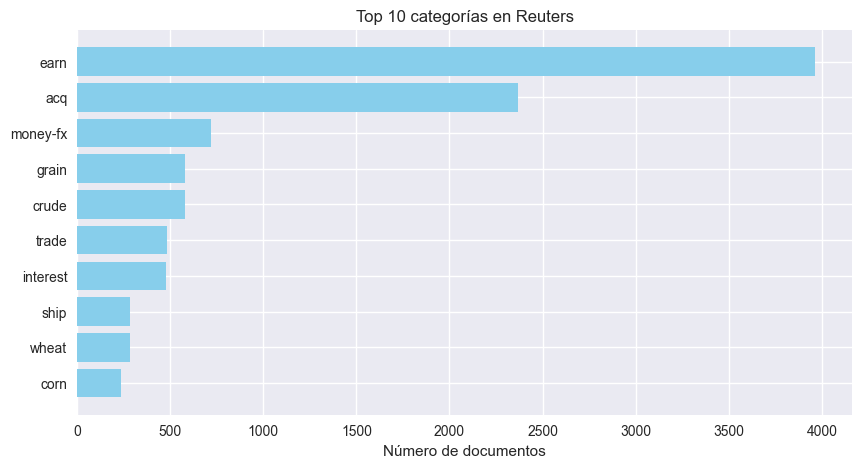

In [238]:
import matplotlib.pyplot as plt
from collections import Counter

# Contar documentos por categoría
category_counts = Counter()
for doc_id in reuters.fileids():
    category_counts.update(reuters.categories(doc_id))

print("\nTop 10 categorías más frecuentes:")
for category, count in category_counts.most_common(10):
    print(f"{category}: {count} documentos")

top_categories = [cat for cat, _ in category_counts.most_common(10)]
counts = [count for _, count in category_counts.most_common(10)]

plt.figure(figsize=(10, 5))
plt.barh(top_categories[::-1], counts[::-1], color='skyblue')  # Invertir para orden descendente
plt.xlabel("Número de documentos")
plt.title("Top 10 categorías en Reuters")
plt.show()

In [243]:
from sklearn.cluster import KMeans

embeddings = model.embeddings.weight.data.cpu().numpy()
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)

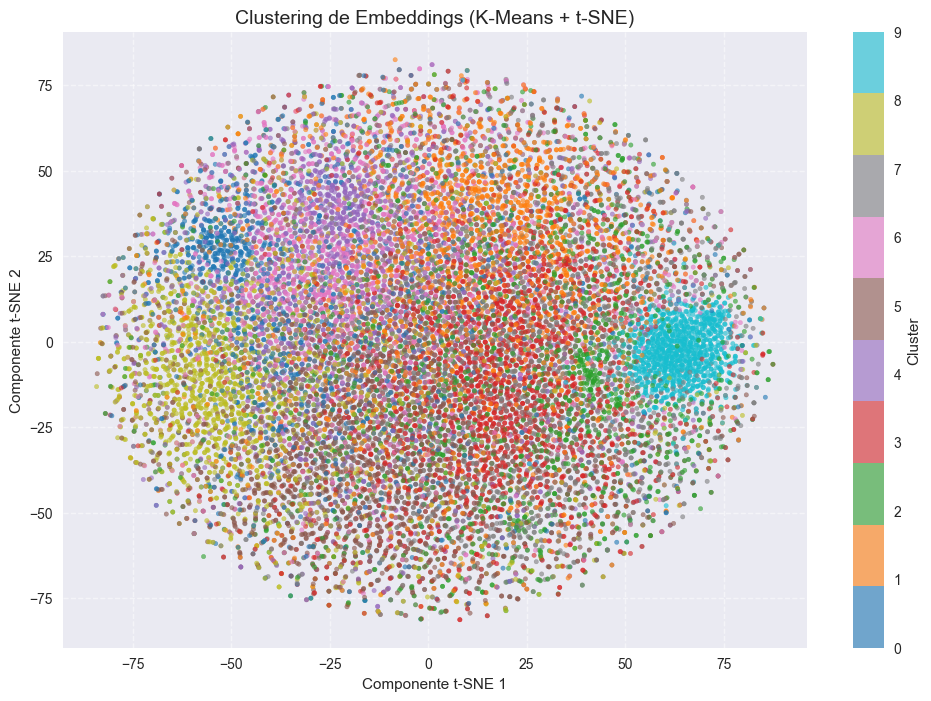

In [244]:

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1], 
    c=clusters, 
    cmap="tab10",
    alpha=0.6,
    s=10
)


plt.colorbar(scatter, label='Cluster')
plt.title("Clustering de Embeddings (K-Means + t-SNE)", fontsize=14)
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [245]:
from collections import defaultdict

valid_words = list(set([word for sentence in corpus for word in sentence]))
# 1. Agrupar palabras por cluster
cluster_to_words = defaultdict(list)
for word, cluster_id in zip(valid_words, clusters):
    cluster_to_words[cluster_id].append(word)

# 2. Encontrar palabras más cercanas al centroide de cada cluster
for cluster_id in range(n_clusters):
    # Obtener palabras del cluster
    words_in_cluster = cluster_to_words[cluster_id]
    
    # Obtener el centroide del cluster
    centroid = kmeans.cluster_centers_[cluster_id]
    
    # Calcular distancias al centroide
    word_indices = [valid_words.index(w) for w in words_in_cluster]
    word_vectors = embeddings[word_indices]
    distances = np.linalg.norm(word_vectors - centroid, axis=1)
    
    # Ordenar palabras por distancia (las más cercanas primero)
    sorted_indices = np.argsort(distances)
    top_words = [words_in_cluster[i] for i in sorted_indices[:10]]
    
    print(f"\nCluster {cluster_id} - Palabras representativas:")
    for word in top_words:
        print(f"  • {word}")


Cluster 0 - Palabras representativas:
  • knuckle
  • 298
  • magnetic
  • resigning
  • pti
  • leahy
  • dominion
  • thrid
  • should
  • schulman

Cluster 1 - Palabras representativas:
  • meru
  • mww
  • hees
  • maurizio
  • prudency
  • perceptions
  • shipbroker
  • thunderstorms
  • cypm
  • 336

Cluster 2 - Palabras representativas:
  • reagan
  • kohlberg
  • commodity
  • disputes
  • mnr
  • della
  • sue
  • steyr
  • vague
  • combine

Cluster 3 - Palabras representativas:
  • 80th
  • dramatised
  • applications
  • dell
  • cropland
  • cattani
  • engines
  • negates
  • slough
  • malrite

Cluster 4 - Palabras representativas:
  • tilney
  • fraudalent
  • pared
  • jukardi
  • disassociated
  • bean
  • distilleries
  • reflection
  • ry
  • complaining

Cluster 5 - Palabras representativas:
  • diceon
  • 273p
  • comtech
  • 375p
  • sfgd
  • immediatley
  • electrospace
  • scientifics
  • vi
  • detect

Cluster 6 - Palabras representativas:
  • globe
  • silfe

### Conclusiones

Como conclusiones finales, se tiene que en sí no se logró capturar una buena relación semántica. Desde el entrenamiento de la red se tuvo problemas ya que le costaba bastante que la perdida baje, parece que le faltaría mucho más épocas. 

Algunos experimentos realizados fue hacer la limpieza y lematización antes de entrenamiento, pero los resultados no mejoraron, así mismo la pérdida se mantuvo de 3 a 4 unidades.

Algunas posibles razones se le puede adjudicar a la red neuronal, posiblemente necesite ser un poco más refinada, dejar más épocas de entrenamiento, y tal vez mejorar el corpus de entrenamiento para que capture mejor estas relaciones.

También se podría experimentar con n-gramas más grandes, y una red más profunda tal vez.

Algo que podemos notar es que para lo clusters parece que sí logra tener capturar ciertos agrupamientos, pero para la mayoría si sigue siendo demasiado dispersos. Pero podemos notar que sí de una manera pobre, logra hacer una segmentación, aunque, lo mismo, no es tan evidente.